# (Project Title)
## Team Members: Altair Aguelo (A17435920), Ashton Bothun (A17388030), Gavin Guyal (), Jason Tang (A17438070)

# 1. Introduction & Predictive Task

## Dataset Description
Source: https://cseweb.ucsd.edu/~jmcauley/datasets.html#twitch <br>
Basic Properties <br>
> The raw data is Twitch metadata. The columns of the data include a Twitch user's ID, a stream ID, the streamer's username, time start, and time stop. Time start and time stop are in increments of 10 minutes, representing how long a user watches that specific stream/streamer. So, each row of data accounts for a specific Twitch user and an instance of them watching a stream. The full dataset has 15.5M data points. For the purposes of this project, we will be using the subset of 100k users in our model/training/exploration. <br>

## Predictive Task
> Our task we chose is to predict whether a user will watch a specific streamer. Models that would be appropriate for this task include logistic regression or latent factor models like factorization machines, temporal based latent factor models, and sequential recommendation models. Since our dataset includes users and "item consumption" through the streamers they watch, we can also form relevant user and item/streamer features. These features can be used to describe user behaviors/history, and in the inverse sense streamer metrics/history. Time is also an important feature that can be used to better map user behavior. This task is relevant to real life applications because a good model could be used to predict future user and streamer behavior. It would be a good way to help with possibly recommending users new streamers to watch or on the flip side help streamers grow as well as see what kind of audience they are reaching.

## Evaluation Metrics and Model Prediction Validity
> To evaluate our model, we will split our data into a training and test set. We will also need to create an evaluation file to predict on. This file will help us evaluate our model. Becuase our data is only made up of "positive" instances where the user watches a streamer, the evaluation file will be a mix of data from the test set and negative samples. Negative samples would be a user never watching a certain streamer. Evaluating in this way will allow us to measure the accuracy of our model, letting us view true positives, false positives, true negatives, and false negatives. It ensures our model is actually recommending smartly, and not just looking for positive/watched instances. 

## Possible Baselines
> The first baseline would be to predict the most popular streamer in our dataset. Just by getting the streamer username that comes up the most. If we use the most popular from our dataset then there will already be a minimum number that will be accurate since that streamer username already appears the most in our data. To beat the baseline our predictions would hopefully find other streamer usernames that would be tailored based on the similarities, latent factor, and other features of who they have watched rather than just the most popular.
> Another baseline would be a "model" that utilizes time. An interesting feature for prediction would be to predict that a user will watch a streamer if they have watched that streamer within the past 3 days. We could do this by doing a little bit of math in our dataset, calculating 3 days before a data point's start time for a user (based on increments of 10 minutes), and checking if the user watched the queried streamer in the past 3 days. This method would work in this dataset but for real life datasets would be a little bit more complicated and have to consider constantly updating databases/user data.


# 2. Exploratory Data Analysis and Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("100k_a.zip", compression='zip', header=None, names=[
    "user_id",
    "streamID",
    "streamer_username",
    "time_start",
    "time_end"
])
df["duration"] = (df["time_end"].astype(int) - df["time_start"]).astype(int) * 10
print(df.head())

   user_id     streamID streamer_username  time_start  time_end  duration
0        1  33842865744          mithrain         154       156        20
1        1  33846768288             alptv         166       169        30
2        1  33886469056          mithrain         587       588        10
3        1  33887624992              wtcn         589       591        20
4        1  33890145056         jrokezftw         591       594        30


In [3]:
print("Number of Interactions:", len(df))
print("Unique Users:", df['user_id'].nunique())
print("Unique Streamers:", df['streamer_username'].nunique())
print("Unique Stream IDs (broadcast segments):", df['streamID'].nunique())
print("Unique Time Windows:", df['time_start'].nunique())

print("\nAverage interactions per user:", df.groupby('user_id').size().mean())
print("Average interactions per streamer:", df.groupby('streamer_username').size().mean())

Number of Interactions: 3051733
Unique Users: 100000
Unique Streamers: 162625
Unique Stream IDs (broadcast segments): 739991
Unique Time Windows: 6148

Average interactions per user: 30.51733
Average interactions per streamer: 18.765460415065334


Dataset used is gathered from snapshots of available streams among ten minute intervals throughout 43 days. It consists of a subset of 100,000 user who have joined a stream 3,051,733 times, and watched 162,625 unique streamers. Average interactions per user and streamer could be used to show that our users rather like to explore, while a streamer has less since it depends on who views their stream.

In [4]:
#Check for nulls
df.isnull().sum() / len(df) * 100

user_id              0.0
streamID             0.0
streamer_username    0.0
time_start           0.0
time_end             0.0
duration             0.0
dtype: float64

In [5]:
#most popular streamers by unique user interactions
unique_user_counts = (
    df.groupby("streamer_username")["user_id"]
      .nunique()
      .sort_values(ascending=False)
)
print(unique_user_counts.head(10))

streamer_username
ninja           17154
tfue            14460
shroud          11011
riotgames        7747
sodapoppin       5982
nickmercs        5953
dakotaz          5939
fortnite         5721
timthetatman     5367
symfuhny         5263
Name: user_id, dtype: int64


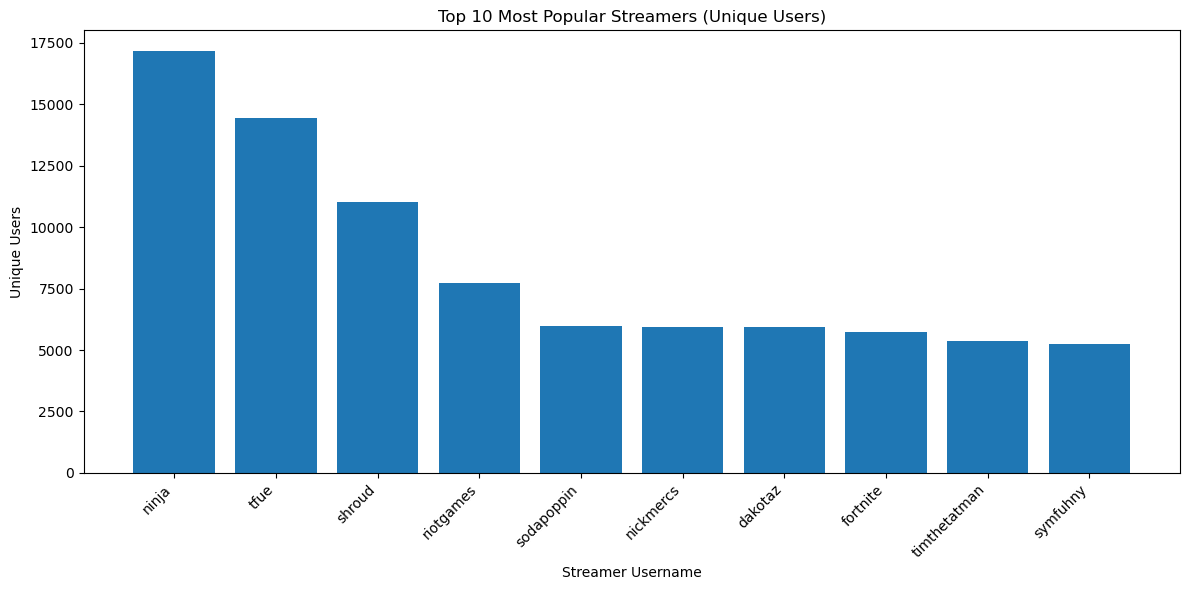

In [6]:
top10 = unique_user_counts.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top10.index, top10.values)
plt.title("Top 10 Most Popular Streamers (Unique Users)")
plt.xlabel("Streamer Username")
plt.ylabel("Unique Users")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

To help with the baseline we got the most popular streamer based on unique viewer. Or in our case the person who has been interacted the most with all the users.

In [7]:
num_users = df['user_id'].nunique()
num_streamers = df['streamer_username'].nunique()
num_interactions = len(df)

sparsity = 1 - (num_interactions / (num_users * num_streamers))
print("User-Streamer Matrix Sparsity:", sparsity)

User-Streamer Matrix Sparsity: 0.9998123453958494


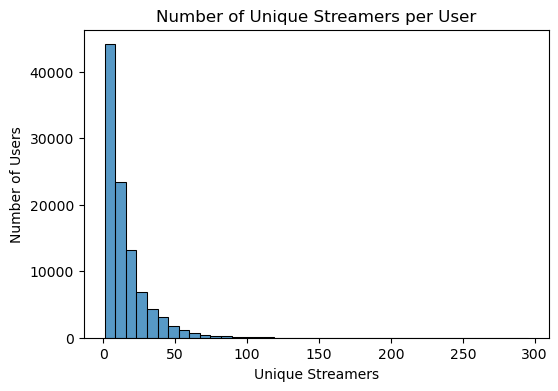

Average unique streamers per user: 15.05158
Median: 10.0


In [8]:
unique_streamers_per_user = df.groupby('user_id')['streamer_username'].nunique()

plt.figure(figsize=(6,4))
sns.histplot(unique_streamers_per_user, bins=40)
plt.title("Number of Unique Streamers per User")
plt.xlabel("Unique Streamers")
plt.ylabel("Number of Users")
plt.show()

print("Average unique streamers per user:", unique_streamers_per_user.mean())
print("Median:", unique_streamers_per_user.median())


The sparsity and graph showcase that the users does not like to go around and are more loyal to a select few streamers, it could also mean that the popular streamers bring in one time twitch users.

In [9]:
# popularity in terms of straight views
most_watch_counts = (
    df.groupby("streamer_username")["user_id"]
      .count()
      .sort_values(ascending=False)
)
print(most_watch_counts.head(10))

streamer_username
ninja         45144
tfue          40136
shroud        27362
riotgames     17633
sodapoppin    14590
nickmercs     14047
dakotaz       13902
asmongold     13186
summit1g      13039
esl_csgo      12547
Name: user_id, dtype: int64


In [10]:
most_watched_by_time = (
    df.groupby("streamer_username")["duration"]
      .sum()
      .sort_values(ascending=False)
)
print(most_watched_by_time.head(10))

streamer_username
ninja         1114940
tfue          1066720
shroud         749340
riotgames      711480
asmongold      540700
sodapoppin     522600
dakotaz        430590
summit1g       427240
xqcow          407160
esl_csgo       394150
Name: duration, dtype: int32


Along with popular by the number of unique users, we also wanted to see the most popular by time and viewership, which is different since some streamers may showcase bigger events or also be streaming more. This showcases more of the quality of the streamer (if they stream a lot or get a lot of viewers) rather than their reach.

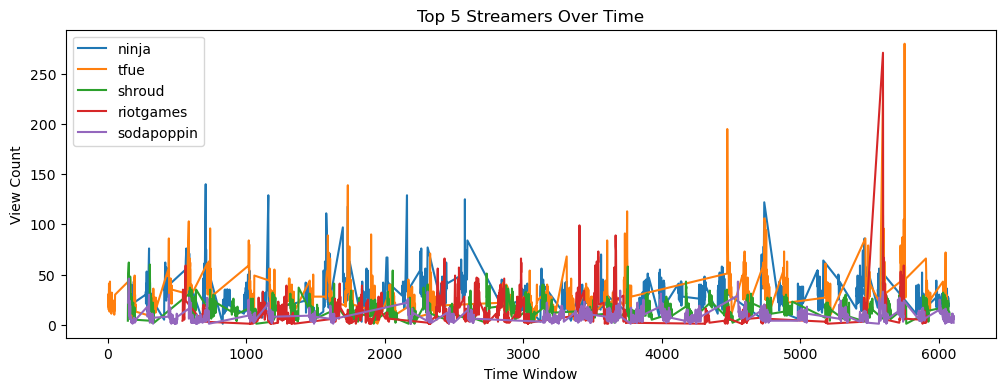

In [11]:
streamer_counts = df.groupby('streamer_username').size()
top5 = streamer_counts.sort_values(ascending=False).head(5).index
df_top5 = df[df['streamer_username'].isin(top5)]

plt.figure(figsize=(12,4))
for s in top5:
    plt.plot(df_top5[df_top5['streamer_username'] == s].groupby('time_start').size(), label=s)

plt.legend()
plt.title("Top 5 Streamers Over Time")
plt.xlabel("Time Window")
plt.ylabel("View Count")
plt.show()

## Creating Train/Test Split and Prediction Files
> This code breaks the data into a train test split for our predictions. We wanted it to be similar to assignment 1 where we could predict data using a file that has pairs: a user, a possible streamer watched, and the true/false value of whether or not they would watch that streamer (the value of true is 1 and false is 0 in our case). We used an 80/20 split for our train/test data. To make our test data better represent real predictions, we sampled negatively, putting into the file users with streamers they have not interacted with. The ratio of watched to non-watched interactions is 1:1. To help with the time based data, we also wanted to keep track of the time start for any interactions. 

In [12]:
import pandas as pd
import random

# load data
df = pd.read_csv("100k_a.zip", compression='zip', header=None, names=[
    "user_id",
    "streamID",
    "streamer_username",
    "time_start",
    "time_end"
])
df["duration"] = (df["time_end"].astype(int) - df["time_start"]).astype(int) * 10

# Sort by time to do a temporal split (Past -> Train, Future -> Test)
df = df.sort_values('time_start')
# Split: 80% Train, 20% Test
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

#save train interactions to own file
train_df.to_csv("train_interactions.csv", index=False)
print("train interactions saved to train_interactions.csv")

# Helper: Create a dictionary of what users have already watched (to avoid bad negatives)
all_streamers = list(df['streamer_username'].unique())
user_watched_history = df.groupby('user_id')['streamer_username'].apply(set).to_dict()

#create test pairs for test prediction file
test_pairs = []

for index, row in test_df.iterrows():
    user_id = row['user_id']
    streamer = row['streamer_username']
    time_start = row['time_start']
    
    # 1. Add the POSITIVE sample (Real Watch)
    test_pairs.append({
        'userID': user_id,
        'streamer_username': streamer,
        'time_start': time_start,
        'ground_truth': 1
    })
    
    # 2. Add the NEGATIVE sample (Fake Watch)
    # Pick a random streamer this user has NEVER watched
    while True:
        random_streamer = random.choice(all_streamers)
        if random_streamer not in user_watched_history.get(user_id, set()):
            break
            
    test_pairs.append({
        'userID': user_id,
        'streamer_username': random_streamer,
        'time_start': time_start,
        'ground_truth': 0
    })

# Convert to DataFrame
evaluation_df = pd.DataFrame(test_pairs)
# Save to CSV
evaluation_df.to_csv("test_pairs.csv", index=False)
print("Evaluation pairs saved to test_pairs.csv")

# test pairs without ground truth for predictions
pairs_df = evaluation_df.drop(columns=['ground_truth'])
pairs_df.to_csv("prediction_pairs.csv", index=False)
print("Prediction pairs saved to prediction_pairs.csv")

train interactions saved to train_interactions.csv
Evaluation pairs saved to test_pairs.csv
Prediction pairs saved to prediction_pairs.csv


# 3. Modeling

## Baseline Models

### Popular Streamer Model
> This model takes the training data and finds the top 10 most popular streamers in that data. For each user streamer pair in the test set, the model predicts if the user will watch that streamer based on the top 10 most popular streamers. If the streamer being queried is one of those top streamers, the model predicts that the user will watch the streamer, otherwise it will predict the user won't. We wrote this file to predictions_Watch_popular.csv for viewing purposes, and compared the predictions in that file to the ground truth values in the test_pairs.csv file. Doing this comparison allowed us to see the accuracy of the model. We can see that the popularity model is pretty bad on its own, yielding around a 53% accuracy. This makes sense as the twitch ecosystem is so large. There are so many users and streamers, and users have many different preferences and possible streamers to watch.

In [13]:
import pandas as pd

# We load the training data to "learn" who is popular.
print("Loading training data...")
train_df = pd.read_csv('train_interactions.csv')

# Logic: Find the top 10 most popular streamers in the training set
top_10_streamers = set(train_df['streamer_username'].value_counts().head(10).index.tolist())
print("Top 10 Streamers:", top_10_streamers)

# We read 'prediction_pairs.csv', apply our logic, and write to 'predictions_Watch_popular.csv'
print("Making predictions...")

# Open the files
input_file = open('prediction_pairs.csv', 'r')
output_file = open('predictions_Watch_popular.csv', 'w')

# Handle Headers
# Read the header from input so we don't process it as data
_ = input_file.readline() 
# Write the header to our output file
output_file.write("userID,streamer_username,prediction\n")

for line in input_file:
    # 1. Parse the line (User, Streamer, Time)
    # strip() removes the newline character, split(',') breaks it into parts
    line = line.strip()
    if not line: continue # skip empty lines
    
    parts = line.split(',')
    u = int(parts[0])
    streamer = parts[1]
    
    # 2. Apply Model Logic
    if streamer in top_10_streamers:
        pred = 1
    else:
        pred = 0
        
    # 3. Write Prediction
    output_file.write(f"{u},{streamer},{pred}\n")

# Close files to ensure data is saved
input_file.close()
output_file.close()
print("Predictions saved to 'predictions_Watch_popular.csv'")

print("Evaluating accuracy...")

# Load the Ground Truth (The "Answer Key")
ground_truth_df = pd.read_csv('test_pairs.csv')

# Load Your Predictions (The "Student Answers")
predictions_df = pd.read_csv('predictions_Watch_popular.csv')

# Check Accuracy
# Note: Since we processed the files sequentially, the rows align perfectly.
correct_predictions = (ground_truth_df['ground_truth'] == predictions_df['prediction']).sum()
accuracy = correct_predictions / len(ground_truth_df)

print(f"Baseline Model Accuracy: {accuracy:.4f}")

Loading training data...
Top 10 Streamers: {'summit1g', 'dakotaz', 'tfue', 'shroud', 'nickmercs', 'ninja', 'asmongold', 'riotgames', 'esl_csgo', 'sodapoppin'}
Making predictions...
Predictions saved to 'predictions_Watch_popular.csv'
Evaluating accuracy...
Baseline Model Accuracy: 0.5334


### Recently Watched Model
> This model takes the whole dataset in order to use recently watched streams from a user's history. For each user streamer pair in the test set, the model predicts if the user will watch that streamer based on if they had watched that streamer in the past 3 days. If the streamer being predicted for is one that shows up in the user's 3 day history, the model predicts that the user will watch that streamer. We also wrote this file to a csv file (predictions_Watch_recent.csv) to view and compare against the ground truth test file/values. Checking this model's accuracy, it performed considerably better than the popularity model, getting around a 61% accuracy. This model performing better makes sense because the behavior of watching someone you watch regularly is common. 

In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score

# We load all the data to build user watch histories. To prevent cheating/memorizing test data, the prediction later makes sure to not look into the future.
print("Loading all data...")\
# load data
df = pd.read_csv("100k_a.zip", compression='zip', header=None, names=[
    "user_id",
    "streamID",
    "streamer_username",
    "time_start",
    "time_end"
])
df["duration"] = (df["time_end"].astype(int) - df["time_start"]).astype(int) * 10
df = df.sort_values('time_start')

print("Building history lookup...")
# Create a dictionary: { user_id: [(time, streamer), (time, streamer)...] }
# We use the FULL dataset for history lookups, but we will filter by time later
# to ensure we don't "cheat" (peek into the future).
user_history = df.groupby('user_id').apply(
    lambda x: list(zip(x['time_start'], x['streamer_username']))
).to_dict()

# We read 'pairs_Watch.csv', apply our logic, and write to 'predictions_Watch.csv'
print("Making predictions...")

# Open the files
input_file = open('prediction_pairs.csv', 'r')
output_file = open('predictions_Watch_recent.csv', 'w')

# Handle Headers
# Read the header from input so we don't process it as data
_ = input_file.readline() 
# Write the header to our output file
output_file.write("userID,streamer_username,prediction\n")

WINDOW_SIZE = 432  # Define recent window size of 3 days

def predict_recent_watch(user, target_streamer, current_time):
    """
    Returns 1 if user watched streamer in [current_time - 432, current_time).
    Returns 0 otherwise.
    """
    # Get history for this user (or empty list if new user)
    history = user_history.get(user, [])
    
    for (past_time, past_streamer) in history:
        # SAFETY CHECK: If we hit a record from the future (or same time), STOP.
        # This prevents data leakage.
        if past_time >= current_time:
            break
            
        # Check if it's within the 3-day window
        if past_time >= (current_time - WINDOW_SIZE):
            if past_streamer == target_streamer:
                return 1
                
    return 0

for line in input_file:
    # 1. Parse the line (User, Streamer, Time)
    # strip() removes the newline character, split(',') breaks it into parts
    line = line.strip()
    if not line: continue # skip empty lines
    
    parts = line.split(',')
    u = int(parts[0])
    streamer = parts[1]
    t = int(parts[2])  # Current time for this prediction
    
    # 2. Apply Model Logic
    pred = predict_recent_watch(u, streamer, t)
        
    # 3. Write Prediction
    output_file.write(f"{u},{streamer},{pred}\n")

# Close files to ensure data is saved
input_file.close()
output_file.close()
print("Predictions saved to 'predictions_Watch_recent.csv'")

print("Evaluating accuracy...")

# Load the Ground Truth (The "Answer Key")
ground_truth_df = pd.read_csv('test_pairs.csv')

# Load Your Predictions (The "Student Answers")
predictions_df = pd.read_csv('predictions_Watch_recent.csv')

# Check Accuracy
# Note: Since we processed the files sequentially, the rows align perfectly.
correct_predictions = (ground_truth_df['ground_truth'] == predictions_df['prediction']).sum()
accuracy = correct_predictions / len(ground_truth_df)

print(f"Baseline Model Accuracy: {accuracy:.4f}")

Loading all data...
Building history lookup...


C:\Users\altai\AppData\Local\Temp\ipykernel_7112\1110941528.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_history = df.groupby('user_id').apply(


Making predictions...
Predictions saved to 'predictions_Watch_recent.csv'
Evaluating accuracy...
Baseline Model Accuracy: 0.6193


## Our Model

In [ ]:
import numpy as np
import math
import pandas as pd

# Load train data
train_df = pd.read_csv('train_interactions.csv')

# 1. USERS PER STREAMER (Equivalent to ratingsPerItem)
# We need this to calculate Jaccard between two streamers
users_per_streamer = train_df.groupby('streamer_username')['user_id'].apply(set).to_dict()

# 2. STREAMER POPULARITY
streamer_popularity = train_df['streamer_username'].value_counts().to_dict()

# 3. USER HISTORY WITH TIMESTAMPS (Equivalent to ratingsPerUser)
# We need time to filter out "future" interactions during feature extraction, sorted by time
user_history_lookup = train_df.groupby('user_id').apply(
    lambda x: list(zip(x['time_start'], x['streamer_username']))
).to_dict()

# streamers a user has watched (for quick negative sampling)
user_watched_history = train_df.groupby('user_id')['streamer_username'].apply(set).to_dict()
print("Lookups built.")

C:\Users\altai\AppData\Local\Temp\ipykernel_7112\770140480.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_history_lookup = train_df.groupby('user_id').apply(


Lookups built.


In [ ]:
def jaccard_score(set1, set2):
    """Helper to calculate Jaccard Similarity between two sets"""
    numer = len(set1.intersection(set2))
    denom = len(set1.union(set2))
    if denom > 0:
        return numer / denom
    return 0

def extract_features(user, target_streamer, current_time, user_history_lookup, users_per_streamer_lookup):
    feats = []
    
    # 1. Get valid history
    # We sort strictly by time to ensure no leakage
    full_history = user_history_lookup.get(user, [])
    valid_history = [x for x in full_history if x[0] < current_time]
    
    # Feature 1: Popularity (Log Scale)
    pop_count = streamer_popularity.get(target_streamer, 0)
    feats.append(math.log(pop_count + 1))
    
    # Feature 2: Max Jaccard Similarity (Item-Item CF)
    # "How similar is this streamer to others I have watched?"
    max_sim = 0
    
    # Get the audience of the target streamer
    target_audience = users_per_streamer_lookup.get(target_streamer, set())
    
    if len(target_audience) > 0:
        # Loop through user's past streamers
        for _, past_streamer in valid_history:
            past_audience = users_per_streamer_lookup.get(past_streamer, set())
            
            sim = jaccard_score(target_audience, past_audience)
            if sim > max_sim:
                max_sim = sim
                
    feats.append(max_sim)

    # Feature 3: Temporal Decay Score
    decay_score = 0
    lambda_param = 0.001 
    
    for t, s in valid_history:
        if s == target_streamer:
            delta_t = current_time - t
            decay_score += math.exp(-lambda_param * delta_t)
            
    feats.append(decay_score)

    # Feature 4: 3-Day Window (Binary)
    recent_flag = 0
    for t, s in valid_history:
        if s == target_streamer and (current_time - t) <= 432:
            recent_flag = 1
            break
            
    feats.append(recent_flag)
    
    return feats

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import random
import math

# 1. Prepare Training Data Arrays
print("Preparing Training Features...")
X_train = []
y_train = []

# List of all streamers for negative sampling
all_streamers = list(train_df['streamer_username'].unique())
count = 0
# Iterate through datapoints in train interactions file
for _, row in train_df.iterrows():
    user_id = row['user_id']
    # The Positive Sample (Real Watch)
    # We KNOW this is a real watch, so we hard-code y=1
    f_pos = extract_features(
        row['user_id'], 
        row['streamer_username'], 
        row['time_start'], 
        user_history_lookup,       # user history dictionary
        users_per_streamer  # users per streamer dictionary
    )
    X_train.append(f_pos)
    y_train.append(1)       

    # The Negative Sample (Fake Watch)
    # We generate a fake example to teach the model what a "0" looks like
    
    # Pick a random streamer they haven't watched
    while True:
        neg_streamer = random.choice(all_streamers)
        if neg_streamer not in user_watched_history.get(user_id, set()):
            break
    
    f_neg = extract_features(
        row['user_id'], 
        neg_streamer, 
        row['time_start'], # Use same time context
        user_history_lookup, 
        users_per_streamer
    )
    X_train.append(f_neg)
    y_train.append(0)       
    count += 1
    if count % 1000 == 0:
        print(f"Processed {count} rows...", end='\r')
print(f"Training data ready. Samples: {len(y_train)}")

# 2. Train the Model
print("Training Logistic Regression...")
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# 3. Prepare Test Data
print("Preparing Test Features...")
test_pairs = pd.read_csv("test_pairs.csv")
X_test = []
y_test = [] # Ground Truth

for _, row in test_pairs.iterrows():
    f = extract_features(row['userID'], row['streamer_username'], row['time_start'], 
                         user_history_lookup, users_per_streamer)
    X_test.append(f)
    y_test.append(row['ground_truth'])

# 4. Predict and Evaluate
print("Evaluating...")
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)

print(f"Logistic Regression Model Accuracy: {acc:.4f}")

# 5. Interpret Weights
print("\nFeature Weights:")
feature_names = ["Popularity", "Max Jaccard Sim", "Time Decay", "3-Day Recency"]
for name, weight in zip(feature_names, model.coef_[0]):
    print(f"{name}: {weight:.4f}")

Preparing Training Features...
Training data ready. Samples: 4882772
Training Logistic Regression...
Preparing Test Features...
Evaluating...
Logistic Regression Model Accuracy: 0.9265

Feature Weights:
Popularity: 0.9708
Max Jaccard Sim: 94.9949
Time Decay: 21.4734
3-Day Recency: 9.6910


## Training (train/test split and evalation metric like acc AUC, MSE, precision...)

# 4. Evaluation

# 5. Related Work